In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import random
import math
import os
import time
%matplotlib inline

To generate slides run 

```bash
  jupyter nbconvert genetic_pendulum.ipynb --to slides --post serve
```

# Genetic algorithms (GAs) with an example

Mike Smith

![running things](./images/running_things.gif) Geijtenbeek et al. 2013

The giraffes above were created using a genetic algorithm (in addition to other techniques). In this tutorial we'll learn the basics of GAs by fitting a function.

GAs will be used to fit a randomly generated sin function:

## The function: 

$ f(x) = p_0 \cdot \sin(\, p_1 \cdot x + p_2) + p_3 $

We need to find $p_0, p_1, p_2, \text{and} \, p_3$.

In [2]:
def fn(x, ps = [1.0, 1.0, 0.0, 0.0]):
    return ps[0] * np.sin(ps[1] * x + ps[2]) + ps[3]

This is boilerplate for making the log directory, and defining the graphical comparison between the estimated function and the ground truth:

In [3]:
logdir = "figs/{}".format(int(time.time()))
os.mkdir(logdir)

def compare(ps, gt_xs, gt_ys, generation, tag, logdir=logdir, show=True, fn=fn):
    """ Compare the results of two different variable lists """
    plt.figure(figsize=(12, 4))

    p_fn = [fn(gt_x, ps) for gt_x in gt_xs]
    
    plt.plot(gt_xs, p_fn, color="orange", label=ps)
    plt.plot(gt_xs, gt_ys, "+", color="black")
    plt.legend()
    plt.title("Generation {:03d}".format(generation))
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.ylim(np.min(gt_ys) - 0.1, np.max(gt_ys) + 0.1)
    plt.show() if show else plt.savefig("{}/{:03d}_{}.png".format(logdir, generation, tag))
    plt.close()

Let's define the ground truth ``gt`` and visualise it:

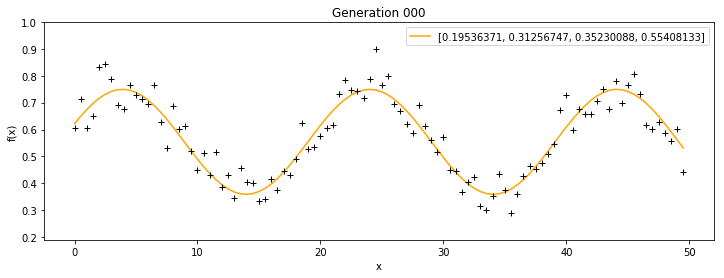

In [4]:
gt = [0.19536371, 0.31256747, 0.35230088, 0.55408133]

gt_xs = np.arange(0, 50.0, 0.5)
gt_ys = [fn(gt_x, gt) + 0.05 * np.random.randn() for gt_x in gt_xs]

compare(gt, gt_xs, gt_ys, 0, "gt")

Now that we have the function we want to fit, we need to know what a GA is exactly, so

## What is a genetic algorithm?

Essentially a mathematical model inspired by natural selection.

## How do we emulate natural selection?

![ga diagram](./images/ga.png)

The above diagram shows a typical genetic algorithm training cycle.

We need:

  1. A definition of an individual.
  2. A way to measure an individual's fitness.
  3. A way to breed a couple to create children.
  4. A way to randomly mutate an individual.

## What is an individual?



![ind](./images/individual.png)

An individual in this case is a numpy array populated with random numbers in the half open interval, and has shape ``[ps, alleles]``. We can take the mean across the allele axis to retrieve the individual's ps.

In [5]:
def generate_first_pop(pop_size=100, ps=4, alleles=8):
    """ Generate a randomly populated generation of individuals. """
    return np.random.random(size=[pop_size, ps, alleles])

## How do we measure an individual's fitness?

Need a comparison between the individual and the ground truth.

In our continuous variable case we could use:
    
$$ MAE = \frac{\sum_{i=1}^n \left| \, \text{ground truth}_i - \text{individual}_i \, \right|}{n} $$

We would take each point in the ground truth values (shown below), and find the distance between them and the values predicted via the individual's ps. We would then take the mean of this residual to find the MAE.

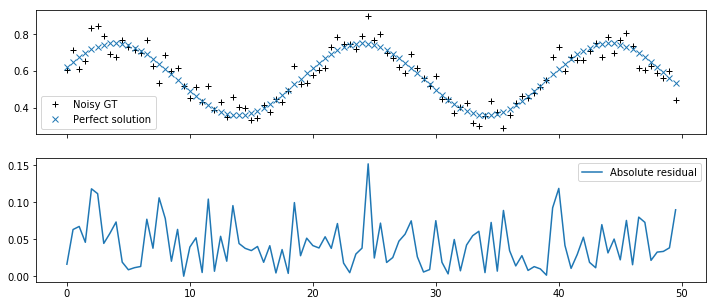

In [6]:
gt_ind = [fn(gt_x, gt) for gt_x in gt_xs] # "perfect" solution

fig, axs = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
axs[0].plot(gt_xs, gt_ys, "+", color="black", label="Noisy GT")
axs[0].plot(gt_xs, gt_ind, "x", label="Perfect solution")
axs[1].plot(gt_xs, np.abs(np.subtract(gt_ys, gt_ind)), label="Absolute residual")
[ax.legend() for ax in axs.ravel()]
plt.show()

The fitness function coded in python:

In [7]:
def fitness(ps, gt_xs, gt_ys, func=fn):
    """ Calculate mean absolute error for an individual's ps. """
    p_fn = np.array([fn(gt_x, np.mean(ps, axis=1)) for gt_x in gt_xs])

    loss = np.mean(np.abs(np.subtract(p_fn, gt_ys)))
    return loss

And if the fitness function is working, we should be able to select the fittest individuals to mate, improving the mean fitness with each generation:

![fitness_meme](./images/small_fitness_meme.jpg)

## How do we generate a new generation?

Since each individual is a numpy array, we can just randomly select alleles from each parent:

In [8]:
def give_birth(ind1, ind2):
    """ Give birth to a child by mixing alleles. """
    allele_mask = np.random.rand(*ind1.shape) > 0.5
    return np.where(allele_mask, ind1, ind2)

## How do we mutate an individual?

In this case, since each individual is a numpy array, we could just randomly replace its alleles:

In [9]:
def mutate(pop, p=0.05):
    """ Randomly mutate alleles in a population. """
    allele_mask = np.random.rand(*pop.shape) > p
    new_alleles = np.random.random(size=pop.shape)
    return np.where(allele_mask, pop, new_alleles)

## Putting it all together:

In [10]:
# These functions are used to sort the fittest inds, 
# randomly select n lucky inds, 
# and mate the next pop into existence.

def sort_fittest(pop, gt_xs, gt_ys):
    """ Sort the fittest individuals from a population """
    return pop[np.argsort([fitness(ind, gt_xs, gt_ys) for ind in pop])]

def get_n_luckies(pop, n=20):
    """ Get n randomly selected individuals from a population """
    return pop[np.random.choice(len(pop), size=n)]

def generate_next_pop(inds, n_children=4):
    """ Get next population by creating children. """
    next_pop = [give_birth(inds[i], inds[len(inds) - 1 - i]) for i in range(len(inds)//2) for j in range(n_children)]
    return np.array(next_pop)

def log_outputs():
    compare(np.mean(fittest[0], axis=1), gt_xs, gt_ys, 
            generation=generation, show=False, tag="fittest")
    compare(np.mean(fittest[50], axis=1), gt_xs, gt_ys, 
            generation=generation, show=False, tag="median")
    compare(np.mean(fittest[-1], axis=1), gt_xs, gt_ys, 
            generation=generation, show=False, tag="least_fit")

Here we have the genetic loop. Here is a pseudocode description of what's going on:

```
1. Generate a population.

Loop for 100 generations:
  2. Sort the population in order of fitness. 
  3. Select 20 "lucky" individuals from the bottom 70% of the populace
       to reduce the likelihood of getting stuck in a local minima. 
  4. Create the next generation by breeding the fittest 30% of the 
       population and the 20 lucky individuals. 
  5. Mutate the population.  
```

In [11]:
pop = generate_first_pop()

fitnesses_list = []
pbar = trange(1, 101)
for generation in pbar:
    # Get population fitness
    fitnesses = [fitness(ind, gt_xs, gt_ys) for ind in pop]
    fitnesses_list.append(fitnesses)
    
    # Sort the individuals in order of fit to not fit
    fittest = sort_fittest(pop, gt_xs, gt_ys)
    
    # Some outputs to log
    log_outputs()
    pbar.set_description("ff: {:.4f}, mean: {}".format(np.mean(fitnesses_list[-1]), np.mean(pop, axis=(0, 2))))
    
    # Get 20 "lucky" individuals selected from the bottom 70% of the populace
    luckies = get_n_luckies(fittest[:-70], n=20)
    
    # Breed the parents to make the next generation and mutate
    breeders = np.random.permutation(np.concatenate((fittest[:30], luckies)))
    pop = generate_next_pop(breeders)
    pop = mutate(pop)

ff: 0.0795, mean: [0.21940179 0.31928053 0.41447751 0.55089329]: 100%|██████████| 100/100 [01:09<00:00,  1.46it/s]


Generate some nice log outputs:

In [12]:
%%bash -s "$logdir"
# This generates some gifs of the learning process
convert -delay 20 $1/???_fittest.png $1/fittest.gif
convert -delay 20 $1/???_median.png $1/median.gif
convert -delay 20 $1/???_least_fit.png $1/least_fit.gif

In [13]:
%%capture
# This generates the loss figure
plt.figure(figsize=(12, 4))
plt.plot(np.max(fitnesses_list, axis=1), label="Least fit")
plt.plot(np.median(fitnesses_list, axis=1), label="Median fitness")
plt.plot(np.min(fitnesses_list, axis=1), label="Most fit")
plt.title("Fitness across generations")
plt.xlabel("Generation")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.savefig("{}/losses.png".format(logdir))

## Results

![losses](./images/losses.png)

First is least fit, then median fitness, then most fit.

![least_fit](./images/least_fit1.gif) 
![median](./images/median1.gif) 

 ![fittest](./images/fittest1.gif)

## Some interesting applications of GAs

* [Antenna design](https://doi.org/10.2514/6.2006-7242)
* [Lens design](https://doi.org/10.1007/s12596-018-0497-3)
* [Travelling saleman problem](https://towardsdatascience.com/evolution-of-a-salesman-a-complete-genetic-algorithm-tutorial-for-python-6fe5d2b3ca35)
* [Teaching a robot to walk](https://www.cs.ubc.ca/~van/papers/2013-TOG-MuscleBasedBipeds/index.html)
* [Bankruptcy prediction](https://doi.org/10.1016/S0957-4174%2802%2900051-9)
* [A viable alternative to gradient descent for reinforcement learning](https://arxiv.org/abs/1712.06567)
* [When GAs go wrong...](https://arxiv.org/abs/1803.03453)